# My version of the code

In [24]:
# imports
from pySpectralPDE.pySpectralPDE import spectralPDE
from scipy.interpolate import RegularGridInterpolator
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import deepxde as dde
import numpy as np

import scipy as sp
import matplotlib.pyplot as plt


The 1D Burgers' equation is a simple non-linear model of waves that may be useful for modelling phenomena such as supersonic flows, turbulent flows, more-complex hydrodynamics, highway traffic, etc. The PDE for the Burgers' equation is given as

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 c}{\partial x^2}$$

where $u$ is the height of the wave and $\nu$ is a constant coefficient.


In [35]:
# define the domain for DeepXDE data structures
x_min, x_max = -1, 1
t_min, t_max = 0, 0.99
n_data = 100

# define the problem variables
nu = 0.1 / np.pi
# nu = 0.5 / np.pi


In [36]:
# numerical solution to Burgers' with pySpectralPDE since I can't get my analytical solution to work
def u0(x):
    return -np.sin(np.pi * x)

params = dict(nu=nu, N=100, xL=x_min, xR=x_max, dt=0.0001, t0=t_min, tmax=t_max)
sol = spectralPDE.setup_solver(u0, params)
u_analytical = params["data"].T


In [45]:
# Defining PDE to model a physical system. 
## In this case, we model the Burgers' equation, which is a simple model of nonlinear waves


# formulate the residual function for the partial differential equation
def pde(x, u):
    # x: is the vector of inputs [x, t]
    ## j = 0 means the partial with respect to x
    ## j = 1 means the partial with respect to t 
    # u: the output, wave height at [x, t]
    du_x = dde.grad.jacobian(u, x, j=0)
    du_xx = dde.grad.hessian(u, x, j=0)
    du_t = dde.grad.jacobian(u, x, j=1)
    
    # move everything in the equation over to one side and set to 0
    return (du_t + u * du_x - nu * du_xx)


# define the initial conditions for t=0
def initial(x):
    # x is [x, t], so need to cut to get the "position" 
    return -np.sin(np.pi * x[:, 0:1])


spatial_domain = dde.geometry.Interval(x_min, x_max)
temporal_domain = dde.geometry.TimeDomain(t_min, t_max)
spatiotemporal_domain = dde.geometry.GeometryXTime(spatial_domain, temporal_domain)

spatial_data = np.expand_dims(np.linspace(x_min, x_max, n_data), 1)
# temporal_data = params["t"]
temporal_data = np.expand_dims(np.linspace(t_min, t_max, n_data), 1)
spatial_data_mesh, temporal_data_mesh = np.meshgrid(spatial_data, temporal_data)
input_data = np.dstack((spatial_data_mesh, temporal_data_mesh)).reshape(-1, 2)

# define boundary and initial conditions for DeepXDE
## we have Dirichlet boundary conditions b/c we are given the value of the function (and not some other thing like velocity, acceleration, or flux) at the boundaries
## lambda X: boundary_vals is a mini-function that returns boundary_vals for every value of X input by DDE in its internal computations
bc = dde.icbc.DirichletBC(spatiotemporal_domain, lambda x: 0, lambda _, on_boundary: on_boundary)

# ic = dde.icbc.IC(spatiotemporal_domain, initial, lambda _, on_initial: on_initial)
ic = dde.icbc.IC(
    spatiotemporal_domain, initial, lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    spatiotemporal_domain, # domain geometry
    pde, # system model
    [bc, ic], # residuals to minimize
    num_domain=100000, # number of residual points in the spacetime domain, sampled uniformly. Increasing this gives more training points which can increase trained model accuracy.
    num_boundary=1000, # number of residual points in the boundary condition
    num_initial=1000, # number of residual points in the initial condition
)


Compiling model...
Building feed-forward neural network...
'build' took 0.040106 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/usr/local/lib/python3.8/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2023-02-20 22:59:34.264953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 22:59:34.265188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 22:59:34.265345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] suc

'compile' took 0.386571 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.84e-02, 1.26e-01, 8.05e-01]    [9.84e-02, 1.26e-01, 8.05e-01]    []  
1000      [7.08e-03, 2.04e-03, 9.56e-03]    [7.08e-03, 2.04e-03, 9.56e-03]    []  
2000      [1.19e-03, 1.43e-04, 5.78e-04]    [1.19e-03, 1.43e-04, 5.78e-04]    []  
3000      [8.19e-04, 1.60e-05, 1.38e-04]    [8.19e-04, 1.60e-05, 1.38e-04]    []  
4000      [2.36e-04, 4.13e-06, 4.99e-05]    [2.36e-04, 4.13e-06, 4.99e-05]    []  
5000      [1.36e-04, 2.04e-06, 3.16e-05]    [1.36e-04, 2.04e-06, 3.16e-05]    []  
6000      [3.15e-04, 4.98e-06, 1.01e-04]    [3.15e-04, 4.98e-06, 1.01e-04]    []  
7000      [4.89e-03, 1.14e-04, 9.52e-04]    [4.89e-03, 1.14e-04, 9.52e-04]    []  
8000      [5.62e-05, 9.30e-07, 1.36e-05]    [5.62e-05, 9.30e-07, 1.36e-05]    []  
9000      [4.81e-05, 7.84e-07, 8.87e-06]    [4.81e-05, 7.84e-07, 8.87e-06]    []  
10000   

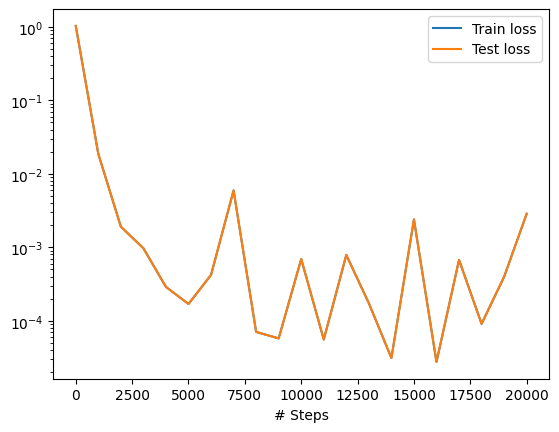

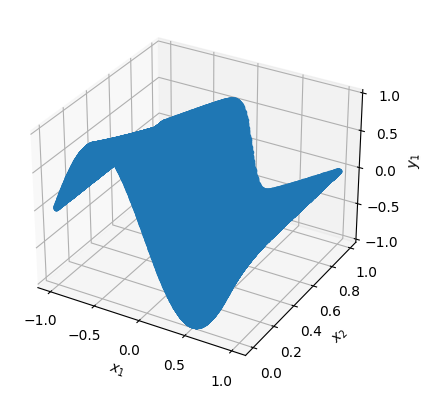

In [46]:
# define neural network 
## fully-connected neural network with:
### input-layer of size 2 b/c we have x and t as inputs
### output-layer of size 1 b/c we have u as output

# activation functions from tensorflow: https://www.tensorflow.org/api_docs/python/tf/keras/activations
# initialization for neural network weights for tensorflow def initializer_dict_tf():" in https://deepxde.readthedocs.io/en/latest/_modules/deepxde/nn/initializers.html
layer_size = [2] + [64] * 4 + [64] + [1] # number of neurons in each layer
net = dde.nn.FNN(layer_size, "tanh", "Glorot normal")

#Training the model
model = dde.Model(data, net)
model.compile(
    "adam", #Optimizer, some other options include "L-BFGS-B". 
    ## You could also change the optimizer during training as mentioned by Prof. Tartakovsky is done in practice for many problems 
    ## (b/c SGD methods tend not to converge, but the loss oscillates), so often they switch to a quasi-Newtonian optimizer at the end of training.
    lr=0.001, #Learning rate. 0.001 is the default for Adam. Others optimizers like L-BFGS-B don't require this parameter
    loss_weights=[10,1,1] # Weights of each term in the loss function. 
    ## Loss weights are weights associated with: [PDE (residual), bc_l, bc_r, ic] since that is the order they are given when we define the TimePDE datastructure
    )

losshistory, train_state = model.train(epochs=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [47]:
u_model = model.predict(input_data)
u_model = np.reshape(u_model, (n_data, n_data))
# u_model = np.reshape(u_model, (n_data, len(params["t"])))
print(u_model.shape)
print(u_analytical.shape)

# they are different shapes, so down-interpolate u_analytical (up-interpolating u_model creates really bad data, so don't do that)
interp = RegularGridInterpolator((spatial_data[:, 0], params["t"]), u_analytical)
x_mesh, t_mesh = np.meshgrid(spatial_data, temporal_data)

interp_points = np.dstack((x_mesh, t_mesh)).reshape(-1, 2)
u_analytical_interp = interp(interp_points).reshape(x_mesh.shape[1], x_mesh.shape[0])

print(u_analytical_interp.shape)

(100, 100)
(100, 4951)
(100, 100)


In [48]:
# #TODO ok so why is the model output so shitty now? It was fine before
# ## small neural net + large number of samples = weird sinusoidal overfitting behavior.


# # sanity check to make sure analytical and model output are similar shapes
# # # make plots for specific times so I can try to debug my analytical solution
# fig, ax = plt.subplots(2, 2, figsize=(10, 8), dpi=300)

# # ax_curr = ax[0, 0]
# # ax_curr.plot(spatial_data[:, 0], u_model[:, 0], label="PINN")
# # ax_curr.plot(spatial_data[:, 0], u_analytical[:, 0], label="Analytical")
# # ax_curr.legend()

# ax_curr = ax[0, 0]
# pos = 0.25
# ax_curr.plot(spatial_data[:, 0], u_model[:, int(pos * u_model.shape[1])], label="PINN")
# ax_curr.plot(spatial_data[:, 0], u_analytical_interp[:, int(pos * u_analytical_interp.shape[1])], label="Analytical")
# ax_curr.legend()

# ax_curr = ax[0, 1]
# pos = 0.5
# ax_curr.plot(spatial_data[:, 0], u_model[:, int(pos * u_model.shape[1])], label="PINN")
# ax_curr.plot(spatial_data[:, 0], u_analytical_interp[:, int(pos * u_analytical_interp.shape[1])], label="Analytical")

# ax_curr = ax[1, 0]
# pos = 0.75
# ax_curr.plot(spatial_data[:, 0], u_model[:, int(pos * u_model.shape[1])], label="PINN")
# ax_curr.plot(spatial_data[:, 0], u_analytical_interp[:, int(pos * u_analytical_interp.shape[1])], label="Analytical")

# ax_curr = ax[1, 1]
# pos = 0.99
# ax_curr.plot(spatial_data[:, 0], u_model[:, int(pos * u_model.shape[1])], label="PINN")
# ax_curr.plot(spatial_data[:, 0], u_analytical_interp[:, int(pos * u_analytical_interp.shape[1])], label="Analytical")

# plt.show()



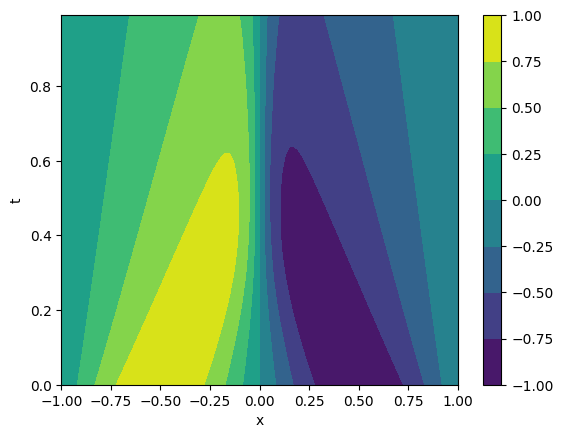

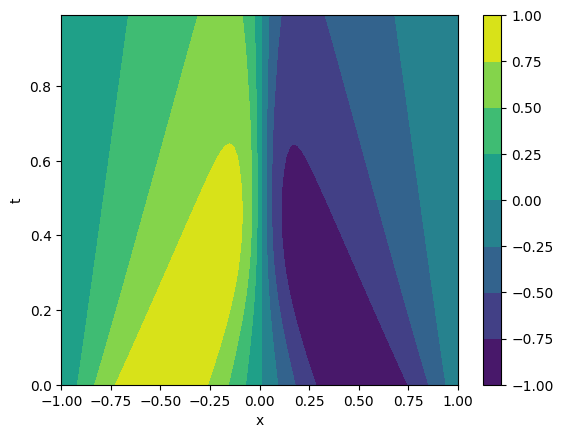

In [49]:
# plot PINN and analytical solution as functions of x and t

# PINN
plt.figure()
plt.contourf(x_mesh, t_mesh, u_model)
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()

# analytical|
plt.figure()
plt.contourf(x_mesh, t_mesh, u_analytical_interp)
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()


In [50]:
print(np.max(np.abs(diff)))

0.11754743754862365


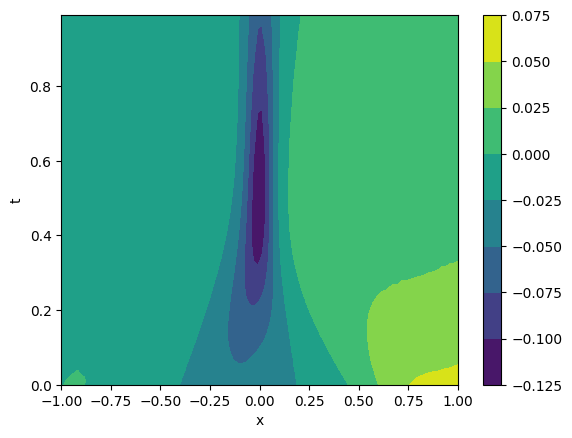

In [51]:
# plot difference between PINN and analytical
diff = (u_model - u_analytical_interp)
plt.contourf(x_mesh, t_mesh, diff)
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()


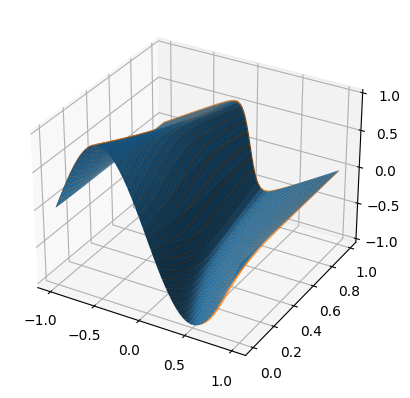

In [20]:
ax = plt.axes(projection ="3d")
ax.plot_surface(spatial_data_mesh, temporal_data_mesh, u_model)
ax.plot_surface(spatial_data_mesh, temporal_data_mesh, u_analytical_interp)

# ax.plot_surface(x_mesh, t_mesh, u_model_interp.T)
# ax.plot_surface(x_mesh, t_mesh, u_analytical.T)


plt.show()

## Code example from DeepXDE website

In [21]:
# taken directly from the DeepXDE website
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)



In [ ]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=15000)

"""
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
"""
dde.saveplot(losshistory, train_state, issave=True, isplot=True)



In [ ]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
nu = 0.1 / np.pi
L = 1
T = 1
N = 1000

# Define the spatial and time domains
x = np.linspace(-L/2, L/2, N)
t = np.linspace(0, T, N)

# Define the Cole's transformation
def coles(u):
    return np.exp(-u / (4 * nu))

# Define the analytical solution to Burger's equation
def u_analytical(x, t):
    u0 = -2 * nu * np.log(coles(np.cos(x / (2 * nu))))
    return 2 * nu * np.log(coles(np.cos(x / (2 * nu)) + t / (2 * nu))) - u0

# Calculate the analytical solution at each point in the domain
u = np.zeros((N, N))
for i in range(N):
    u[i, :] = u_analytical(x, t[i])

# Plot the analytical solution
plt.imshow(u, extent=[-L/2, L/2, 0, T], cmap='jet', aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Analytical Solution to Burger's Equation using Cole's Transformation")
plt.colorbar()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the range of x and t values
x = np.linspace(-6, 6, 200)
t = np.linspace(0.01, 1.0, 100)

# Define the Cole's transformation function
def coles_transform(u, t):
    return np.exp(-u**2 / (4*t)) / np.sqrt(4*np.pi*t)

# Calculate the solution for each time step
for i in range(len(t)):
    u = -2*np.log(coles_transform(x, t[i]))
    plt.plot(x, u, label='t = %.2f' % t[i])

# Add axis labels and legend
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

# Show the plot
plt.show()

In [ ]:
"""
def f_1(y):
    return np.sin(np.pi * y)

def f_2(y):
    return np.exp(- np.cos((np.pi * y) / (2 * np.pi * nu)))

def f_exp(eta, t):
    return np.exp(- eta**2 / (4 * nu * t))

def burgers(x, t):
    # analytical solution to Burgers' equation for a sinusoidal initial condition
    u_out = np.zeros((x.shape[0], t.shape[0]))
    etas = np.linspace(-10, 10, 100)

    # find the value of u for a given value of x and t
    for x_idx, x_curr in enumerate(x):
        for t_idx, t_curr in enumerate(t):
            numerator = 0
            denomenator = 0
            delta_eta = x[1] - x[0] 

            # approximate integrals by using discrete approximation to integral
            for eta in etas:
                numerator += f_1(x_curr-eta) * f_2(x_curr-eta) * f_exp(eta, t_curr) * delta_eta
                denomenator += f_2(x_curr-eta) * f_exp(eta, t_curr) * delta_eta
            
            u_curr = (-1 * numerator) / (denomenator)
            u_out[x_idx, t_idx] = u_curr

    return u_out

u_analytical = burgers(spatial_data, temporal_data)
u_analytical[:, 0] = initial(spatial_data).squeeze()
"""